In [ ]:
!pip -q install ./python

In [1]:
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from config import Config
from model import Actor, Critic
from ddpg_agent import Agent, OUNoise, ReplayBuffer
from multi_agent import MultiAgent

import matplotlib.pyplot as plt
%matplotlib inline

env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
env_info = env.reset(train_mode=True)[brain_name]

In [3]:
config = Config()

config.seed = 2
config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.action_size = brain.vector_action_space_size
config.states = env_info.vector_observations
config.state_size = config.states.shape[1]
config.num_agents = len(env_info.agents)
config.update_every = 4

config.batch_size = 512
config.memory_fn = lambda: ReplayBuffer(config.action_size, config.buffer_size, 
                                        config.batch_size, config.seed)

config.noise_fn = lambda: OUNoise(config.action_size, config.seed)

config.actor_hidden_units = (512,256)
config.actor_network_fn = lambda: Actor(config.action_size, config.state_size, 
                                        config.actor_hidden_units, config.seed).to(config.device)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.actor_learning_rate)

config.critic_hidden_units = (512,256)
config.critic_network_fn = lambda: Critic(config.action_size, config.state_size, 
                                          config.critic_hidden_units, config.seed).to(config.device)
config.critic_optimizer_fn = lambda params: torch.optim.Adam(params, lr=config.critic_learning_rate)




In [34]:
MA = MultiAgent(config)

def maddpg(n_episodes=5000, max_t=4000):
    
    all_scores = []
    max_scores=[]
    
    scores_queue = deque(maxlen=100)
    max_scores_queue = deque(maxlen=100)
    
    done_switch = False
    
    for i_episode in range(1, n_episodes+1):
        
        MA.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for i in range(max_t):
            actions = MA.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            MA.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states


                
        avg_score = np.mean(scores)
        max_score = np.max(scores)
        scores_queue.append(avg_score)
        max_scores_queue.append(max_score)
        max_scores.append(max_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.5f} \tMax Average Score: {:.5f}'.format(i_episode, 
                                                                                       np.mean(scores_queue), 
                                                                                       np.mean(max_scores_queue)), end="")
        if (i_episode-100) % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_queue)))
        
      #  if np.mean(max_scores_queue)>=0.5:
       #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-5, 
        #                                                                                 np.mean(scores_queue)))
         #   torch.save(MA.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
          #  torch.save(MA.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if ((i_episode-100) > 100) & (np.mean(max_scores_queue)>=0.5):
            print('\nFinal Average Score: {:.2f}'.format(np.mean(scores_queue)))
            torch.save(MA.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(MA.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores, max_scores

C:\Users\kaixi\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 7.62395 	Max Average Score: 7.906503
Episode 200	Average Score: 9.73970 	Max Average Score: 9.878100
Episode 201	Average Score: 9.72720 	Max Average Score: 9.87700
Final Average Score: 9.73


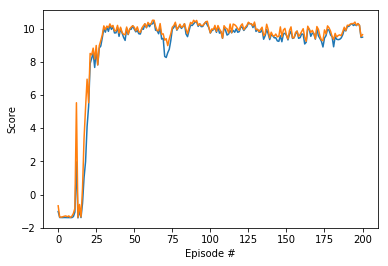

In [35]:
average_scores, max_scores = maddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(average_scores)), average_scores, max_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [42]:
###### MA = MultiAgent(config)

def pretrained_maddpg(n_episodes=5000, max_t=2000):
    
    all_scores = []
    max_scores=[]
    
    scores_queue = deque(maxlen=100)
    max_scores_queue = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
        MA.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(config.num_agents)

        for i in range(max_t):
            actions = MA.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            MA.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
            
            if any(dones):
                break
            
        
                
        avg_score = np.mean(scores)
        max_score = np.max(scores)
        scores_queue.append(avg_score)
        max_scores_queue.append(max_score)
        max_scores.append(max_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.5f} \tMax Average Score: {:.5f}'.format(i_episode, 
                                                                                       np.mean(scores_queue), 
                                                                                       np.mean(max_scores_queue)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_queue)))
        
      #  if np.mean(max_scores_queue)>=0.5:
       #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-5, 
        #                                                                                 np.mean(scores_queue)))
         #   torch.save(MA.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
          #  torch.save(MA.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if (i_episode>100) & (np.mean(max_scores_queue)>=0.5):
            print('\nFinal Average Score: {:.2f}'.format(np.mean(scores_queue)))
            torch.save(MA.ddpg_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(MA.ddpg_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores, max_scores

C:\Users\kaixi\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 1.04320 	Max Average Score: 1.07530
Episode 101	Average Score: 1.06070 	Max Average Score: 1.09320
Final Average Score: 1.06


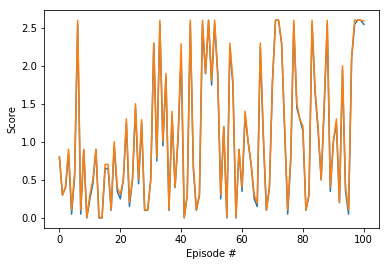

In [43]:
average_scores, max_scores = pretrained_maddpg()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(average_scores)), average_scores, max_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()